# LGBM을 활용한 베이스라인

In [71]:
import pandas as pd
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1. 데이터 로딩

In [3]:
data_dir = '/opt/ml/input/data/train_dataset'
csv_file_path = os.path.join(data_dir, 'train_data.csv')
df = pd.read_csv(csv_file_path) 

In [4]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [5]:
# test data, train에 추가하기(concat)

In [6]:
test_train = pd.read_csv('/opt/ml/input/data/train_dataset/test_data.csv')

In [7]:
test_train = test_train[test_train['answerCode'] != -1]

In [8]:
df = pd.concat([df,test_train])
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
260108,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244


## 2. Feature Engineering

In [9]:
# 문항 번호별 정답률 feature
def que_num_rate(df) :
    
    train_df = df.groupby(['que_num'])['que_num'].count().reset_index(name='que_num_cnt')
    train_ans_df = df.groupby(['que_num'])['answerCode'].sum().reset_index(name='que_ans_cnt')
    train_df = train_df.merge(train_ans_df, on ='que_num', how='left')
    train_df['que_num_rate'] = round(train_df['que_ans_cnt'] / train_df['que_num_cnt'], 2)

    return train_df.loc[:,['que_num','que_num_rate']]


In [10]:
# last Tag에 대한 정답률 함수 생성
def last_tag_rate(df):
    df = df.copy()
    
    last_tag = df.groupby(['userID']).tail(1)
    last_tag_1 = last_tag.loc[:, ['userID','KnowledgeTag']]
    
    user_tag_ans = last_tag_1.merge(df, on=['userID','KnowledgeTag'], how='left')
    
    user_tag_ans['count'] = user_tag_ans.groupby(['userID','KnowledgeTag'])['KnowledgeTag'].transform('count')
    user_tag_ans['tag_cnt'] = user_tag_ans['count']-1
    user_tag_ans['ans_cnt'] = user_tag_ans.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    
    user_tag_ans_rate = user_tag_ans.groupby('userID').tail(1)
    user_tag_ans_rate['ans_cnt'] = user_tag_ans_rate['ans_cnt'].fillna(0)
    user_tag_ans_rate['last_ans_rate'] = round(user_tag_ans_rate['ans_cnt']/ user_tag_ans_rate['tag_cnt'],2)
    user_tag_ans_rate['last_ans_rate'] = user_tag_ans_rate['last_ans_rate'].fillna(0.00)
    
    return user_tag_ans_rate.loc[:,['userID','last_ans_rate']]

In [11]:
def user_test_rate(df):
#     df['index'] = df.index
    u_test_cnt = df.groupby(['userID','testId'])['testId'].cumcount().reset_index(name='u_test_cnt')
    user_test = df.merge(u_test_cnt, on='index', how='left')
    u_test_cnt= user_test.groupby(['userID','testId'])['answerCode'].transform(lambda x: x.cumsum().shift(1)).reset_index(name='test_ans_cnt')
    user_test_ans_sum =  user_test.merge(u_test_cnt, on='index', how='left')
    user_test_ans_sum['test_ans_cnt'] = user_test_ans_sum['test_ans_cnt'].fillna(0.0)
    
    def rating_1(user_test_ans_sum):
        if user_test_ans_sum['u_test_cnt'] == 0:
            return 0.50
        else :    
            return round(user_test_ans_sum['test_ans_cnt']/user_test_ans_sum['u_test_cnt'],2)
        
    user_test_ans_sum['test_ans_rate'] = user_test_ans_sum.apply(rating_1, axis=1)
    
    return user_test_ans_sum.loc[:,['index','u_test_cnt','test_ans_cnt','test_ans_rate']]

In [12]:
# user별 Tag에 대한 정답률 sequential하게 적용
def user_tag_rate(df) :
#     df['index'] = df.index

    u_t_cnt = df.groupby(['userID','KnowledgeTag'])['KnowledgeTag'].cumcount().reset_index(name='u_tag_cnt')
    user_tag =  df.merge(u_t_cnt, on='index', how='left')
    #user_tag['tag_cnt_1'] = user_tag['u_tag_cnt']+1

    u_t_cnt= user_tag.groupby(['userID','KnowledgeTag'])['answerCode'].transform(lambda x: x.cumsum().shift(1)).reset_index(name='ans_cnt')
    user_tag_ans_sum =  user_tag.merge(u_t_cnt, on='index', how='left')
    user_tag_ans_sum['ans_cnt'] = user_tag_ans_sum['ans_cnt'].fillna(0.0)

    def rating(user_tag_ans_sum):
        if user_tag_ans_sum['u_tag_cnt'] == 0:
            return 0.50
        else :    
            return round(user_tag_ans_sum['ans_cnt']/user_tag_ans_sum['u_tag_cnt'],2)
    user_tag_ans_sum['tag_ans_rate'] = user_tag_ans_sum.apply(rating, axis=1)
    
    return user_tag_ans_sum.loc[:,['index','u_tag_cnt','ans_cnt','tag_ans_rate']]

In [13]:
def test_rate(df):
    test_df = df.groupby(['testId'])['testId'].count().reset_index(name='test_cnt')
    test_ans_df = df.groupby(['testId'])['answerCode'].sum().reset_index(name='test_ans_cnt')
    test_df = test_df.merge(test_ans_df, on ='testId', how='left')
    test_df['test_rate'] = round(test_df['test_ans_cnt'] / test_df['test_cnt'], 2)
    test_df['test_rate'] = test_df['test_rate'].fillna(0.00)
    return test_df.loc[:,['testId','test_rate']]

def que_rate(df):
    que_df = df.groupby(['assessmentItemID'])['assessmentItemID'].count().reset_index(name='que_cnt')
    que_ans_df = df.groupby(['assessmentItemID'])['answerCode'].sum().reset_index(name='que_ans_cnt')
    que_df = que_df.merge(que_ans_df, on ='assessmentItemID', how='left')
    que_df['que_rate'] = round(que_df['que_ans_cnt'] / que_df['que_cnt'], 2)
    que_df['que_rate'] = que_df['que_rate'].fillna(0.00)
    return que_df.loc[:,['assessmentItemID','que_rate']]

def tag_rate(df):
    tag_df = df.groupby(['KnowledgeTag'])['KnowledgeTag'].count().reset_index(name='tag_cnt')
    tag_ans_df = df.groupby(['KnowledgeTag'])['answerCode'].sum().reset_index(name='tag_ans_cnt')
    tag_df = tag_df.merge(tag_ans_df, on ='KnowledgeTag', how='left')
    tag_df['tag_rate'] = round(tag_df['tag_ans_cnt'] / tag_df['tag_cnt'], 2)
    tag_df['tag_rate'] = tag_df['tag_rate'].fillna(0.00)
    return tag_df.loc[:,['KnowledgeTag','tag_rate']]

In [14]:
def rating_1(df):
    if df['u_test_cnt'] == 0:
        return 0.50
    else :    
        return round(df['test_ans_cnt']/df['u_test_cnt'],2)
    
def rating_2(df):
    if df['u_tag_cnt'] == 0:
        return 0.50
    else :    
        return round(df['tag_ans_cnt']/df['u_tag_cnt'],2)

In [15]:
def feature_engineering(df):
    
    df['index'] = df.index
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
#     correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
#     correct_t.columns = ["test_mean", 'test_sum']
#     correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
#     correct_k.columns = ["tag_mean", 'tag_sum']

#     df = pd.merge(df, correct_t, on=['testId'], how="left")
#     df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    
    # user_test_ans_rate
    df['u_test_cnt'] = df.groupby(['userID','testId'])['answerCode'].cumcount()
    df['test_ans_cnt'] = df.groupby(['userID','testId'])['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['test_ans_cnt'] = df['test_ans_cnt'].fillna(0.0)
    df['test_ans_rate'] = df.apply(rating_1, axis=1)
    
    # user_tag_seq_ans_rate
    df['u_tag_cnt'] = df.groupby(['userID','KnowledgeTag'])['answerCode'].cumcount()
    df['tag_ans_cnt'] = df.groupby(['userID','KnowledgeTag'])['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['tag_ans_cnt'] = df['tag_ans_cnt'].fillna(0.0)
    df['tag_ans_rate'] = df.apply(rating_2, axis=1)
    #####################################################################################
#     # user_test_ans_rate
#     user_test_ans_rate = user_test_rate(df)
#     df = pd.merge(df, user_test_ans_rate, on='index', how='left')
    
#     # user_tag_seq_ans_rate
#     user_tag_ans_rate = user_tag_rate(df)
#     df = pd.merge(df, user_tag_ans_rate, on='index', how='left')
    ####################################################################################
    
    
#     # last_Tag ans rate
#     last_tag_ans_rate = last_tag_rate(df)
#     df = pd.merge(df, last_tag_ans_rate, on=['userID'], how='left')
    
    # test별 정답률
#     all_test_rate = test_rate(df)
#     df = pd.merge(df, all_test_rate, on='testId', how='left')
    
    # 문항의 순서별 정답률
#     df['que_num'] = df['assessmentItemID'].str.slice(start=7, stop=10)
#     df['que_num'] = df['que_num'].astype(int)
#     que_num_df = que_num_rate(df)
#     df = df.merge(que_num_df, on='que_num', how='left')
    
    
    # 문제별 정답률
#     all_que_rate = que_rate(df)
#     df = pd.merge(df, all_que_rate, on='assessmentItemID', how='left')
    
    # Tag별 정답률
#     all_tag_rate = tag_rate(df)
#     df = pd.merge(df, all_tag_rate, on='KnowledgeTag', how='left')
    
    

    
    return df

In [16]:
df = feature_engineering(df)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,NaN,0,NaN,0,0.0,0.5,0,0.0,0.5
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.0,1,1.0,1.0,0,0.0,0.5
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.0,2,2.0,1.0,1,1.0,1.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.0,3,3.0,1.0,2,2.0,1.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.0,4,4.0,1.0,3,3.0,1.0


In [17]:
def grade_test_level(df):
    df = test_rate(df)
    df['grade'] = df['testId'].str.slice(start=2, stop=3)
    df['grade_test_level'] = df.groupby(['grade'])['test_rate'].rank(method='dense', ascending=False)
    df['grade_test_level'] = df['grade_test_level'].astype(int)
    return df


In [18]:
grade_test_level = grade_test_level(df)
grade_test_level

,testId,test_rate,grade,grade_test_level
0,A010000001,0.92,1,4
1,A010000002,0.93,1,3
2,A010000003,0.84,1,12
3,A010000004,0.88,1,8
4,A010000005,0.85,1,11
...,...,...,...,...
1532,A090000070,0.46,9,12
1533,A090000071,0.34,9,23
1534,A090000072,0.45,9,13
1535,A090000073,0.54,9,6


In [19]:
df = df.merge(grade_test_level, on='testId', how='left')
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,NaN,0,NaN,0,0.0,0.50,0,0.0,0.50,0.95,6,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,2266581,1.0,4,0.250000,4,1.0,0.25,4,1.0,0.25,0.67,3,25
2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,2266582,1.0,5,0.200000,0,0.0,0.50,0,0.0,0.50,0.65,4,29
2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2266583,2.0,6,0.333333,1,1.0,1.00,1,1.0,1.00,0.65,4,29
2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,2266584,3.0,7,0.428571,2,2.0,1.00,2,2.0,1.00,0.65,4,29


In [31]:
df['grade'] = df['grade'].astype(int)
df['user_correct_answer'] = df['user_correct_answer'].fillna(0)

test_rate
all_test_rate = test_rate(df)
# df = pd.merge(df, all_test_rate, on='testId', how='left')

# que_rate
all_que_rate = que_rate(df)
df = pd.merge(df, all_que_rate, on='assessmentItemID', how='left')

# que_num_rate
df['que_num'] = df['assessmentItemID'].str.slice(start=7, stop=10)
df['que_num'] = df['que_num'].astype(int)
que_num_df = que_num_rate(df)
df = df.merge(que_num_df, on='que_num', how='left')

# tag_rate
all_tag_rate = tag_rate(df)
df = pd.merge(df, all_tag_rate, on='KnowledgeTag', how='left')

In [22]:
pd.options.display.max_columns = 1000
df[:10]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate_x,grade,grade_test_level,test_rate_y,que_rate,que_num,que_num_rate,tag_rate
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.50,0.95,6,1,0.95,0.98,1,0.75,0.96
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1,0.95,0.97,2,0.72,0.92
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1,0.95,0.92,3,0.69,0.92
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1,0.95,0.97,4,0.66,0.92
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1,0.95,0.95,5,0.60,0.92
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,5,5.0,5,1.000000,5,5.0,1.00,4,4.0,1.00,0.95,6,1,0.95,0.93,7,0.52,0.92
6,0,A060003001,A060000003,0,2020-03-26 05:52:03,7226,6,6.0,6,1.000000,0,0.0,0.50,0,0.0,0.50,0.79,6,14,0.79,0.89,1,0.75,0.80
7,0,A060003002,A060000003,1,2020-03-26 05:52:10,7226,7,6.0,7,0.857143,1,0.0,0.00,1,0.0,0.00,0.79,6,14,0.79,0.93,2,0.72,0.80
8,0,A060003003,A060000003,1,2020-03-26 05:53:14,7226,8,7.0,8,0.875000,2,1.0,0.50,2,1.0,0.50,0.79,6,14,0.79,0.52,3,0.69,0.80
9,0,A060003004,A060000003,1,2020-03-26 05:53:29,7226,9,8.0,9,0.888889,3,2.0,0.67,3,2.0,0.67,0.79,6,14,0.79,0.82,4,0.66,0.80


In [ ]:
# df[(df['userID'] == 7440) & (df['testId'] == 'A030000136')]

In [ ]:
# df[-10:]

In [ ]:
# df[df['userID']==1]

In [ ]:
# def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
#     # 피처 중요도 순으로 내림차순 정렬
#     df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
#     # 피처 중요도 정규화 및 누적 중요도 계산
#     df['importance_normalized'] = df['importance'] / df['importance'].sum()
#     df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
#     plt.rcParams['font.size'] = 12
#     plt.style.use('fivethirtyeight')
#     # 피처 중요도 순으로 n개까지 바플롯으로 그리기
#     df.loc[:n, :].plot.barh(y='importance_normalized', 
#                             x='feature', color=color, 
#                             edgecolor='k', figsize=figsize,
#                             legend=False)

#     plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
#     plt.title(f'Top {n} Most Important Features', size=18)
#     plt.gca().invert_yaxis()
    
#     return df

## 3. Train/Test 데이터 셋 분리

In [32]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.8, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]
    
    
#     train = train.groupby(['userID','KnowledgeTag']).tail(1)
    #test데이터셋은 각 유저의 마지막 interaction만 추출 (validation)
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [33]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
FEATS = ['user_acc','u_test_cnt','test_ans_rate', 'u_tag_cnt','tag_ans_rate', 'que_num_rate', 'test_rate_y','grade','grade_test_level', 'que_rate']
# FEATS = ['user_acc','que_num_rate', 'test_rate', 'que_rate', 'user_total_answer_test', 'user_correct_answer_test',  'user_acc_test', 'user_total_answer_tag', 'user_acc_tag']
# drop features : 'KnowledgeTag','test_mean', 'test_sum', 'user_total_answer', 'user_correct_answer','tag_mean','tag_sum','test_ans_cnt',  'ans_cnt',  'user_correct_answer_tag',

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [26]:
pd.options.display.max_columns = 1000
train

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate_x,grade,grade_test_level,test_rate_y,que_rate,que_num,que_num_rate,tag_rate
0,0,A060001001,A060000001,2020-03-24 00:17:11,7224,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.50,0.95,6,1,0.95,0.98,1,0.75,0.96
1,0,A060001002,A060000001,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1,0.95,0.97,2,0.72,0.92
2,0,A060001003,A060000001,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1,0.95,0.92,3,0.69,0.92
3,0,A060001004,A060000001,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1,0.95,0.97,4,0.66,0.92
4,0,A060001005,A060000001,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1,0.95,0.95,5,0.60,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,2020-06-05 06:50:21,438,2266581,1.0,4,0.250000,4,1.0,0.25,4,1.0,0.25,0.67,3,25,0.67,0.45,5,0.60,0.69
2525952,7441,A040165001,A040000165,2020-08-21 01:06:39,8836,2266582,1.0,5,0.200000,0,0.0,0.50,0,0.0,0.50,0.65,4,29,0.65,0.64,1,0.75,0.70
2525953,7441,A040165002,A040000165,2020-08-21 01:06:50,8836,2266583,2.0,6,0.333333,1,1.0,1.00,1,1.0,1.00,0.65,4,29,0.65,0.64,2,0.72,0.70
2525954,7441,A040165003,A040000165,2020-08-21 01:07:36,8836,2266584,3.0,7,0.428571,2,2.0,1.00,2,2.0,1.00,0.65,4,29,0.65,0.79,3,0.69,0.70


In [32]:
# train.to_csv('train_embedding.csv')

In [33]:
# train.to_csv('train.csv')

In [34]:
test

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,que_rate,que_num,que_num_rate,tag_rate
5412,6,A030145005,A030000145,2020-10-26 09:52:14,7817,3707,408.0,920,0.443478,4,1.0,0.25,9,1.0,0.11,0.63,0.61,5,0.60,0.62
17719,20,A030156005,A030000156,2020-10-22 07:23:06,1721,13439,421.0,717,0.587169,4,4.0,1.00,11,11.0,1.00,0.68,0.31,5,0.60,0.67
19464,22,A070162008,A070000162,2020-12-15 00:52:18,9122,15184,407.0,605,0.672727,7,4.0,0.57,3,2.0,0.67,0.55,0.15,8,0.46,0.37
29439,32,A070155006,A070000155,2020-12-12 09:55:59,7867,23920,422.0,932,0.452790,5,5.0,1.00,6,6.0,1.00,0.61,0.42,6,0.56,0.60
30387,33,A070161008,A070000161,2020-12-23 04:20:28,9126,24868,545.0,947,0.575502,7,1.0,0.14,2,1.0,0.50,0.45,0.11,8,0.46,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525664,7423,A030150005,A030000150,2020-10-16 11:52:33,7823,2266309,16.0,17,0.941176,4,3.0,0.75,4,3.0,0.75,0.72,0.49,5,0.60,0.68
2525699,7425,A060177006,A060000177,2020-10-23 12:51:49,1579,2266344,13.0,17,0.764706,6,4.0,0.67,2,1.0,0.50,0.72,0.43,6,0.56,0.62
2525775,7429,A040145005,A040000145,2020-10-25 11:19:48,2112,2266420,12.0,21,0.571429,4,4.0,1.00,4,4.0,1.00,0.88,0.76,5,0.60,0.84
2525790,7430,A040149005,A040000149,2020-10-24 09:23:35,2114,2266435,11.0,14,0.785714,4,2.0,0.50,4,2.0,0.50,0.78,0.50,5,0.60,0.72


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2525956 entries, 0 to 2525955
Data columns (total 24 columns):
 #   Column               Dtype  
---  ------               -----  
 0   userID               int64  
 1   assessmentItemID     object 
 2   testId               object 
 3   answerCode           int64  
 4   Timestamp            object 
 5   KnowledgeTag         int64  
 6   index                int64  
 7   user_correct_answer  float64
 8   user_total_answer    int64  
 9   user_acc             float64
 10  u_test_cnt           int64  
 11  test_ans_cnt         float64
 12  test_ans_rate        float64
 13  u_tag_cnt            int64  
 14  tag_ans_cnt          float64
 15  tag_ans_rate         float64
 16  test_rate_x          float64
 17  grade                int64  
 18  grade_test_level     int64  
 19  test_rate_y          float64
 20  que_rate             float64
 21  que_num              int64  
 22  que_num_rate         float64
 23  tag_rate             float64
dty

In [25]:
# test.to_csv('test.csv')

In [26]:
# !pip install lightgbm

In [35]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [36]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증
- catboost로도 해보기

In [37]:
model = lgb.train(
                    {'objective': 'binary',
                    'metric': 'auc'},   #default - binary
                    lgb_train,
                    valid_sets=[lgb_train, lgb_test],
                    verbose_eval=100,
                    num_boost_round=2000,  #default = 500
                    early_stopping_rounds=100
                )

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID ACC : {acc} AUC : {auc}\n')

[LightGBM] [Info] Number of positive: 1322516, number of negative: 697519
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 2020035, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654700 -> initscore=0.639762
[LightGBM] [Info] Start training from score 0.639762
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.830865	valid_1's auc: 0.811917
[200]	training's auc: 0.832128	valid_1's auc: 0.813436
[300]	training's auc: 0.832965	valid_1's auc: 0.814059
[400]	training's auc: 0.833682	valid_1's auc: 0.814733
[500]	training's auc: 0.834346	valid_1's auc: 0.815129
[600]	training's auc: 0.83496	valid_1's auc: 0.815426
[700]	training's auc: 0.835531	valid_1's auc: 

In [ ]:
# INSTALL MATPLOTLIB IN ADVANCE
# _ = lgb.plot_importance(model)

## 5. Inference

In [39]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

In [40]:
test_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,0,NaN,0,NaN,0,0.0,0.50,0,0.0,0.5
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1,1.0,1,1.000000,1,1.0,1.00,1,1.0,1.0
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,2,2.0,2,1.000000,2,2.0,1.00,0,0.0,0.5
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,3,2.0,3,0.666667,3,2.0,0.67,1,0.0,0.0
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,4,2.0,4,0.500000,4,2.0,0.50,0,0.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,260109,8.0,11,0.727273,0,0.0,0.50,0,0.0,0.5
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,260110,8.0,12,0.666667,1,0.0,0.00,1,0.0,0.0
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,260111,9.0,13,0.692308,2,1.0,0.50,0,0.0,0.5
260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,260112,10.0,14,0.714286,3,2.0,0.67,1,1.0,1.0


In [44]:
test_df['grade'] = test_df['grade'].astype(int)
test_df = test_df.merge(grade_test_level, on='testId', how='left')
test_df['user_correct_answer'] = test_df['user_correct_answer'].fillna(0)

# test_rate
# all_test_rate = test_rate(df)
test_df = pd.merge(test_df, all_test_rate, on='testId', how='left')

# que_rate
# all_que_rate = que_rate(df)
test_df = pd.merge(test_df, all_que_rate, on='assessmentItemID', how='left')

# que_num_rate
test_df['que_num'] = test_df['assessmentItemID'].str.slice(start=7, stop=10)
test_df['que_num'] = test_df['que_num'].astype(int)
# que_num_df = que_num_rate(test_df)
test_df = test_df.merge(que_num_df, on='que_num', how='left')

# tag_rate
# all_tag_rate = tag_rate(df)
test_df = pd.merge(test_df, all_tag_rate, on='KnowledgeTag', how='left')

In [42]:
# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

test_df

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate_x,grade,grade_test_level,test_rate_y,que_rate,que_num,que_num_rate,tag_rate
1035,3,A050133008,A050000133,2020-10-26 13:13:57,5289,1035,717.0,1035,0.692754,7,6.0,0.86,11,9.0,0.82,0.66,5,23,0.66,0.53,8,0.46,0.56
1706,4,A070146008,A070000146,2020-12-27 02:47:54,9080,1706,465.0,670,0.694030,7,6.0,0.86,3,2.0,0.67,0.65,7,9,0.65,0.61,8,0.46,0.55
3023,13,A070111008,A070000111,2020-12-27 04:35:09,9660,3023,915.0,1316,0.695289,7,3.0,0.43,6,2.0,0.33,0.46,7,28,0.46,0.37,8,0.46,0.49
4283,17,A090064006,A090000064,2020-10-30 05:48:37,2611,4283,1031.0,1259,0.818904,5,5.0,1.00,5,5.0,1.00,0.45,9,13,0.45,0.27,6,0.56,0.42
4670,26,A060135007,A060000135,2020-10-23 11:44:18,1422,4670,293.0,386,0.759067,6,4.0,0.67,6,4.0,0.67,0.64,6,29,0.64,0.31,7,0.52,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260052,7395,A040122005,A040000122,2020-09-08 02:05:20,10615,260052,7.0,23,0.304348,4,1.0,0.25,2,0.0,0.00,0.79,4,15,0.79,0.45,5,0.60,0.70
260067,7404,A030111005,A030000111,2020-10-13 09:49:18,7636,260067,7.0,14,0.500000,4,2.0,0.50,4,2.0,0.50,0.87,3,5,0.87,0.89,5,0.60,0.82
260082,7416,A050193004,A050000193,2020-10-04 02:44:41,10402,260082,7.0,14,0.500000,3,2.0,0.67,3,2.0,0.67,0.75,5,14,0.75,0.86,4,0.66,0.82
260097,7417,A050193004,A050000193,2020-09-06 13:09:15,10402,260097,2.0,14,0.142857,3,2.0,0.67,3,2.0,0.67,0.75,5,14,0.75,0.86,4,0.66,0.82


In [45]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [37]:
# fi = pd.DataFrame()
# fi['feature'] = [FEATS]
# fi['importance'] = model.feature_importance()
# fi_plot = plot_feature_importances(fi)

In [46]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "output15.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/output15.csv


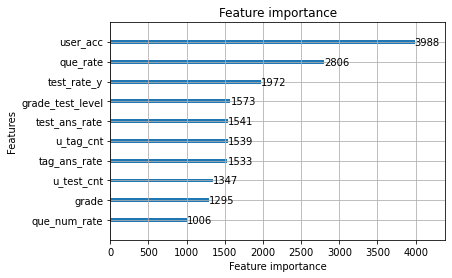

In [47]:
_ = lgb.plot_importance(model)

In [ ]:
_ = lgb.plot_importance(model)

In [62]:
val_preds = model.predict(test[FEATS])

In [63]:
len(val_preds)

1502

In [64]:
val_result = test
val_result['result'] = val_preds
val_result.head()

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate_x,grade,grade_test_level,test_rate_y,que_rate,que_num,que_num_rate,tag_rate,result,answer,pred
5412,6,A030145005,A030000145,2020-10-26 09:52:14,7817,3707,408.0,920,0.443478,4,1.0,0.25,9,1.0,0.11,0.63,3,29,0.63,0.61,5,0.60,0.62,0.207780,0,0
17719,20,A030156005,A030000156,2020-10-22 07:23:06,1721,13439,421.0,717,0.587169,4,4.0,1.00,11,11.0,1.00,0.68,3,24,0.68,0.31,5,0.60,0.67,0.410603,1,0
19464,22,A070162008,A070000162,2020-12-15 00:52:18,9122,15184,407.0,605,0.672727,7,4.0,0.57,3,2.0,0.67,0.55,7,19,0.55,0.15,8,0.46,0.37,0.070822,0,0
29439,32,A070155006,A070000155,2020-12-12 09:55:59,7867,23920,422.0,932,0.452790,5,5.0,1.00,6,6.0,1.00,0.61,7,13,0.61,0.42,6,0.56,0.60,0.620531,1,1
30387,33,A070161008,A070000161,2020-12-23 04:20:28,9126,24868,545.0,947,0.575502,7,1.0,0.14,2,1.0,0.50,0.45,7,29,0.45,0.11,8,0.46,0.37,0.032842,0,0


In [53]:
y_test

5412       0
17719      1
19464      0
29439      1
30387      0
          ..
2525664    1
2525699    0
2525775    1
2525790    0
2525946    0
Name: answerCode, Length: 1502, dtype: int64

In [65]:
val_result['answer'] = y_test

In [66]:
val_result.head()

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate_x,grade,grade_test_level,test_rate_y,que_rate,que_num,que_num_rate,tag_rate,result,answer,pred
5412,6,A030145005,A030000145,2020-10-26 09:52:14,7817,3707,408.0,920,0.443478,4,1.0,0.25,9,1.0,0.11,0.63,3,29,0.63,0.61,5,0.60,0.62,0.207780,0,0
17719,20,A030156005,A030000156,2020-10-22 07:23:06,1721,13439,421.0,717,0.587169,4,4.0,1.00,11,11.0,1.00,0.68,3,24,0.68,0.31,5,0.60,0.67,0.410603,1,0
19464,22,A070162008,A070000162,2020-12-15 00:52:18,9122,15184,407.0,605,0.672727,7,4.0,0.57,3,2.0,0.67,0.55,7,19,0.55,0.15,8,0.46,0.37,0.070822,0,0
29439,32,A070155006,A070000155,2020-12-12 09:55:59,7867,23920,422.0,932,0.452790,5,5.0,1.00,6,6.0,1.00,0.61,7,13,0.61,0.42,6,0.56,0.60,0.620531,1,1
30387,33,A070161008,A070000161,2020-12-23 04:20:28,9126,24868,545.0,947,0.575502,7,1.0,0.14,2,1.0,0.50,0.45,7,29,0.45,0.11,8,0.46,0.37,0.032842,0,0


In [67]:
def answering(val_result):
    threshold = 0.5
    if val_result['result'] >= threshold :
        return 1
    else :
        return 0

val_result['pred'] = val_result.apply(answering, axis=1)

In [68]:
val_result.head()

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate_x,grade,grade_test_level,test_rate_y,que_rate,que_num,que_num_rate,tag_rate,result,answer,pred
5412,6,A030145005,A030000145,2020-10-26 09:52:14,7817,3707,408.0,920,0.443478,4,1.0,0.25,9,1.0,0.11,0.63,3,29,0.63,0.61,5,0.60,0.62,0.207780,0,0
17719,20,A030156005,A030000156,2020-10-22 07:23:06,1721,13439,421.0,717,0.587169,4,4.0,1.00,11,11.0,1.00,0.68,3,24,0.68,0.31,5,0.60,0.67,0.410603,1,0
19464,22,A070162008,A070000162,2020-12-15 00:52:18,9122,15184,407.0,605,0.672727,7,4.0,0.57,3,2.0,0.67,0.55,7,19,0.55,0.15,8,0.46,0.37,0.070822,0,0
29439,32,A070155006,A070000155,2020-12-12 09:55:59,7867,23920,422.0,932,0.452790,5,5.0,1.00,6,6.0,1.00,0.61,7,13,0.61,0.42,6,0.56,0.60,0.620531,1,1
30387,33,A070161008,A070000161,2020-12-23 04:20:28,9126,24868,545.0,947,0.575502,7,1.0,0.14,2,1.0,0.50,0.45,7,29,0.45,0.11,8,0.46,0.37,0.032842,0,0


In [69]:
# 0을 잘 맞춘 정도
TN = len(val_result[(val_result['answer'] == 0) & (val_result['pred'] == 0)])
FP = len(val_result[(val_result['answer'] == 0) & (val_result['pred'] == 1)])

# 1을 잘 맞춘 정도
FN = len(val_result[(val_result['answer'] == 1) & (val_result['pred'] == 0)])
TP = len(val_result[(val_result['answer'] == 1) & (val_result['pred'] == 1)])

print('TN(0을 0으로 맞춤) =', TN)
print('FP(0을 1으로 맞춤) =', FP)
print('FN(1을 0으로 맞춤) =', FN)
print('TP(1을 1으로 맞춤) =', TP)

Acc = (TP+TN)/(TP+TN+FP+FN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1_score = 2*(Recall*Precision)/(Recall+Precision)

print('Acc =', round(Acc,2))
print('Precision =', round(Precision,2))
print('Recall =', round(Recall,2))
print('F1_score =', round(F1_score,2))

TN(0을 0으로 맞춤) = 555
FP(0을 1으로 맞춤) = 220
FN(1을 0으로 맞춤) = 186
TP(1을 1으로 맞춤) = 541
Acc = 0.73
Precision = 0.71
Recall = 0.74
F1_score = 0.73


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


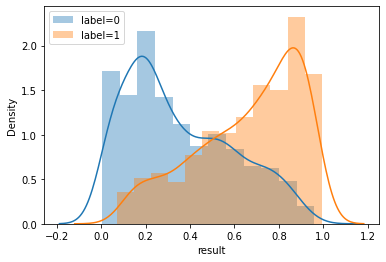

In [72]:
sns.distplot(test[test['answer']==0]['result'], label='label=0')
sns.distplot(test[test['answer']==1]['result'], label='label=1')

plt.legend()
plt.show()